## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [1]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: mecab-python 0.996-ko-0.9.2-msvc has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [150]:
pip install category_encoders

  Obtaining dependency information for category_encoders from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   ---------------------------------------- 81.9/81.9 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: mecab-python 0.996-ko-0.9.2-msvc has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [196]:
pip install bayesian-optimization

DEPRECATION: mecab-python 0.996-ko-0.9.2-msvc has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from category_encoders import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [2]:
df = pd.read_csv("C:/Users/eun01/Downloads/pitching.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [4]:
df1 = df.dropna(axis = 1)
df1.head(10)

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,bechtge01,1871,1,PH1,1,2,3,3,2,0,0,43,23,0,11,1,0,42
1,brainas01,1871,1,WS3,12,15,30,30,30,0,0,361,132,4,37,13,0,292
2,fergubo01,1871,1,NY2,0,0,1,0,0,0,0,8,3,0,0,0,0,9
3,fishech01,1871,1,RC1,4,16,24,24,22,1,0,295,103,3,31,15,0,257
4,fleetfr01,1871,1,NY2,0,1,1,1,1,0,0,20,10,0,3,0,0,21
5,flowedi01,1871,1,TRO,0,0,1,0,0,0,0,1,0,0,0,0,0,0
6,mackde01,1871,1,RC1,0,1,3,1,1,0,0,20,5,0,3,1,0,30
7,mathebo01,1871,1,FW1,6,11,19,19,19,1,0,261,97,5,21,17,2,243
8,mcbridi01,1871,1,PH1,18,5,25,25,25,0,0,285,113,3,40,15,0,223
9,mcmuljo01,1871,1,TRO,12,15,29,29,28,0,0,430,153,4,75,12,0,362


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

In [5]:
df2 = df1['year'].value_counts().reset_index()
df2.columns = ['year', 'counts']
df2

,year,counts
0,2015,809
1,2014,746
2,2009,729
3,2013,726
4,2012,722
...,...,...
140,1872,23
141,1878,22
142,1877,19
143,1871,19


<Axes: xlabel='year', ylabel='counts'>

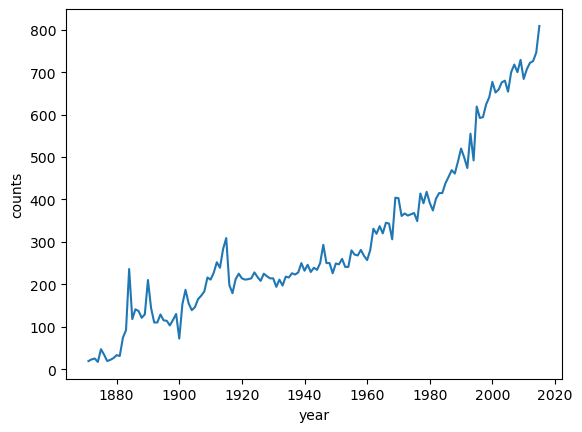

In [6]:
sns.lineplot(x = df2.year, y = df2.counts)

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [7]:
df3 = df1[df1['year']>=1980]
df3.count()

player_id    21157
year         21157
stint        21157
team_id      21157
w            21157
l            21157
g            21157
gs           21157
cg           21157
sho          21157
sv           21157
h            21157
er           21157
hr           21157
bb           21157
so           21157
bk           21157
r            21157
dtype: int64

1.6 reset_index()를 통해 재배열하세요.

In [8]:
df3.reset_index()

,index,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [9]:
df3['w'].values

array([ 8, 12, 14, ..., 13,  0,  0], dtype=int64)

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [10]:
df4 = df3.query('w>0')
df4['w'].values

array([ 8, 12, 14, ...,  1, 11, 13], dtype=int64)

1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [11]:
df4['w'] = np.where(df4['w'] >=10, 1, 0)
df4

C:\Users\eun01\AppData\Local\Temp\ipykernel_11236\2559285796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['w'] = np.where(df4['w'] >=10, 1, 0)


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
22986,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
22988,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44129,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
44130,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
44133,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
44134,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [12]:
df4['w'].value_counts()

0    12589
1     2714
Name: w, dtype: int64

In [13]:
df4.head(10)

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
22986,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
22988,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
22991,arroyfe01,1980,1,MIN,0,6,21,11,1,1,0,97,48,7,32,27,3,55
22992,augusje01,1980,1,ML4,0,3,39,1,0,0,2,83,35,5,36,22,0,37
22993,babcobo01,1980,1,TEX,0,2,19,0,0,0,0,20,12,3,8,15,0,13
22995,bahnsst01,1980,1,MON,0,6,57,0,0,0,4,80,31,7,33,48,0,40
22997,bairdo01,1980,1,CIN,0,6,61,0,0,0,6,91,40,7,39,62,0,42


1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [14]:
df5 = df4.drop(columns = ['player_id', 'year', 'team_id'])

1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [15]:
smote = SMOTE(sampling_strategy='auto', random_state=123)

x = df5.drop(columns='w')
y = df5['w']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 123)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [16]:
y_resampled.value_counts()

0    10127
1    10127
Name: w, dtype: int64

1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

필요한 샘플링 개수보다 더 많은 샘플링을 수행하고 평균을 취하는 기법
장점 : 정보가 손실되지 않음
단점 : 복제된 관측치를 원래 데이터 세트에 추가하기만 하면 여러 유형의 관측치를 다수 추가하여 오버피팅을 초래할 수 있음

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

ADASYN, Borderline-SMOTE etc.

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [17]:
df5[['stint', 'w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so', 'bk', 'r']]

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
22986,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
22988,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44129,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
44130,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
44133,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
44134,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


In [18]:
x = df5.drop('w', axis=1)
y = df5['w']

In [19]:
x_val, x_test, y_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=123) 


x_train, x_val, y_train, y_val = train_test_split(x_val, y_val, test_size=0.25, random_state=123)

In [20]:
print("Training set samples:", len(x_train))
print("Validation set samples:", len(x_val))
print("Test set samples:", len(x_test))

Training set samples: 12152
Validation set samples: 4051
Test set samples: 4051


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

고정된 test data로만 모델의 성능을 확인하고 파라미터를 수정하는 과정을 거치게 되면 최종 모델은 test data에만 성능이 좋은 모델이 됨. 즉, test data에 과적합됨. 여기에 validation set을 추가함으로써 모델 검증을 도움.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [21]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [22]:
RandomForest = RandomForestClassifier(random_state = 123)
RandomSearch = RandomizedSearchCV(estimator = RandomForest, param_distributions = param_grid,
                                 scoring = 'accuracy', random_state = 123)

RandomSearch.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=123),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='accuracy')

In [23]:
print('최적의 하이퍼 파라미터: ', RandomSearch.best_params_)

최적의 하이퍼 파라미터:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

n_estimators : 포레스트의 나무 수
max_depth :트리의 최대 깊이
min_samples_split : 노드가 분할되기 전에 노드에 배치된 최소 데이터 포인트 수
min_samples_leaf : 리프 노드에 허용되는 최소 데이터 포인트 수
bootstrap : 데이터 포인트를 샘플링하는 방법(교체 유무)
criterion :분할 성능 측정 기능

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [24]:
RandomForest = RandomForestClassifier(random_state = 123)
GridSearch = GridSearchCV(estimator = RandomForest, param_grid = param_grid,
                                 scoring = 'accuracy', cv=5)

GridSearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [25]:
print('최적의 하이퍼 파라미터: ', GridSearch.best_params_)

최적의 하이퍼 파라미터:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

* GridSearchCV : 시도할 하이퍼파라미터들을 지정하면 모든 조합에 대해 교차검증 후 가장 좋은 성능을 내는 하이퍼파라미터 조합을 찾음. 하이퍼 파라미터 값들이 많아지면 시간이 오래걸림
* RandomizedSearchCV : GridSearch 와 동일한 방식으로 사용하지만 모든 조합을 다 시도하지는 않고, 각 반복마다 임의의 값만 대입해 지정한 횟수만큼 평가함

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [29]:
RF = RandomForestClassifier()
search_space = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

Bayes = BayesSearchCV(RF,search_space,scoring='accuracy')
Bayes.fit(x_train, y_train)

BayesSearchCV(estimator=RandomForestClassifier(), scoring='accuracy',
              search_spaces={'bootstrap': [True, False],
                             'criterion': ['gini', 'entropy'],
                             'max_depth': [None, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 4],
                             'min_samples_split': [2, 5, 10],
                             'n_estimators': [10, 50, 100, 200]})

In [30]:
print('최적 하이퍼 파라미터 :', Bayes.best_params_)

최적 하이퍼 파라미터 : OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 30), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [ ]:
random_search = RandomizedSearchCV(estimator=RF, param_distributions=search_space, scoring='accuracy', cv=3, n_iter=50)
random_search.fit(x_train, y_train)

grid_search = GridSearchCV(estimator=RF, param_grid=search_space, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)

Bayes = BayesSearchCV(RF, search_space, scoring='accuracy', cv=3)
Bayes.fit(x_train, y_train)

In [ ]:
RF_p = random_search.best_params_
G_p = grid_search.best_params_
B_p = Bayes.best_params_

random = RF_p.predict(x_val)
grid = G_p.predict(x_val)
bayes = B_p.predict(x_val)

In [ ]:
print(f'RandomForest score : {accuracy_score(y_val, rf)}' )
print(f'Grid score : {accuracy_score(y_val, gr)}' )
print(f'Bayesian score : {accuracy_score(y_val, bay)}' )

### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [ ]:
RF = RandomForestClassifier(n_estimators=100, random_state=123)
LR = LogisticRegression(max_iter=1000, random_state=123)

voting_clf = VotingClassifier(estimators=[('rf', RF), ('lr', LR)], voting='hard')

voting_clf.fit(x_train, y_train)

y_pred = voting_clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("Voting Classifier의 정확도:", accuracy)